# RunAge 

> Lucas Santana  
> Laboratory of Biomechanics and Motor Control ([http://demotu.org/](http://demotu.org/))  
> Federal University of ABC, Brazil

Primeiramente, as bibliotecas que foram utilizadas ao decorrer do código para encontrar a potência no tornozelo estão dispostas na linha de código a seguir, principalmente as utilizadas para realizar operações matemáticas e para gerar gráficos.

In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys, os
sys.path.insert(1, r'./../functions')
from scipy import signal, misc
import scipy.signal

%load_ext autoreload
%autoreload 2
from IPython.display import display, Math, Latex
from mpl_toolkits.mplot3d import Axes3D
sys.path.insert(1, r'./../functions')  # add to pythonpath
# scipy and numpy have too many future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Input

 Para obter os parâmetros dos segmentos perna e pé foram utilizados os valores relacionados à antropometria do sujeito, sendo eles: massa (M) e altura (H). Além disso, foi estabelecido o valor da aceleraão da gravidade (g) de acordo com a norma ISO 80000-3:2006, bem como o quanto o tempo varia em cada frame (dt) de acordo com a frequência de aquisicão dos dados. 

In [2]:
M = 73.1 # Mass (Kg)
H = 1.7430 # Height (m)
g = 9.80665  # m/s2, standard acceleration of free fall (ISO 80000-3:2006)
dt = 1/150

# Method for finding virtual markers

In [3]:
fileDir = r'C:\Users\ebm\Desktop\Lucas Santana\RunAge\WBDStxt'

## Read data

A seguir está o local utilizado para selecionar o sujeito (subj), tentativa realizada por ele (trial) e a plataforma (fplat) corresponde a tentativa. Como em cada tentativa o sujeito pisa de forma corretamente (somente um pé na plataforma) em poucas ou as vezes em 1 ou nenhuma plataforma, o número dela deve ser digitado de forma correta para evitar resultados equivocados. Para tal, substituir todos os números na variável "fplat".

In [4]:
subj = 'WBDS36'
trial = 'walkO13'
fplat = ['Fx4','Fy4','Fz4','COPx4','COPy4','COPz4','Ty4']

In [5]:
# read column labels
nameS = subj + 'static1.txt'
fnameS = os.path.join(fileDir, nameS)
dfS = pd.read_csv(fnameS, sep='\t', header='infer', skiprows=0, index_col=0, engine='c')
markerLabelsStatic = dfS.columns.tolist()

### Shank markers static

In [6]:
shankMarkersS = dfS[['R.HFX', 'R.HFY', 'R.HFZ', 'R.TTX', 'R.TTY', 'R.TTZ',
                     'R.KneeX', 'R.KneeY', 'R.KneeZ',
                     'R.Knee.MedialX', 'R.Knee.MedialY', 'R.Knee.MedialZ',
                     'R.AnkleX', 'R.AnkleY', 'R.AnkleZ','R.Ankle.MedialX', 
                     'R.Ankle.MedialY', 'R.Ankle.MedialZ']]
shankMarkersS = shankMarkersS/1000 # convert to meter
# shank markers
rknl = np.mean(shankMarkersS[['R.KneeX', 'R.KneeY', 'R.KneeZ']].values, axis=0)
rknm = np.mean(shankMarkersS[['R.Knee.MedialX', 'R.Knee.MedialY', 'R.Knee.MedialZ']].values, axis=0)
rhfi = np.mean(shankMarkersS[['R.HFX', 'R.HFY', 'R.HFZ']].values, axis=0)
rtti = np.mean(shankMarkersS[['R.TTX', 'R.TTY', 'R.TTZ']].values, axis=0)
rlml = np.mean(shankMarkersS[['R.AnkleX', 'R.AnkleY', 'R.AnkleZ']].values, axis=0)
rmml = np.mean(shankMarkersS[['R.Ankle.MedialX', 'R.Ankle.MedialY', 'R.Ankle.MedialZ']].values, axis=0)
rajc = (rlml+rmml)/2

In [7]:
def shankIOR(rhfi,rtti,rlml,rajc):
    """Calculates the shank coordinate system using the convention of IOR and CAST
    """
    # CAST and IOR shank
    xShank = np.cross(rhfi-rajc,rlml-rajc)
    zShank = np.cross(xShank,rtti-rajc)
    yShank = np.cross(zShank,xShank)
    # Normalizing
    xShank = xShank/np.linalg.norm(xShank)
    yShank = yShank/np.linalg.norm(yShank)
    zShank = zShank/np.linalg.norm(zShank)

    shankCAST = np.array([xShank,yShank,zShank])

    return shankCAST

In [8]:
# Shank coordinate system
shankCAST = shankIOR(rhfi,rtti,rlml,rajc)

### Foot markers static

In [9]:
footMarkersS = dfS[['R.HeelX', 'R.HeelY', 'R.HeelZ', 'R.MT1X', 'R.MT1Y', 'R.MT1Z', 
                    'R.MT2X', 'R.MT2Y', 'R.MT2Z', 'R.MT5X', 'R.MT5Y', 'R.MT5Z']]
footMarkersS = footMarkersS/1000 # convert to meters

# foot markers
rhee = np.mean(footMarkersS[['R.HeelX', 'R.HeelY', 'R.HeelZ']].values, axis=0)
rmt1 = np.mean(footMarkersS[['R.MT1X', 'R.MT1Y', 'R.MT1Z']].values, axis=0)
rmt2 = np.mean(footMarkersS[['R.MT2X', 'R.MT2Y', 'R.MT2Z']].values, axis=0)
rmt5 = np.mean(footMarkersS[['R.MT5X', 'R.MT5Y', 'R.MT5Z']].values, axis=0)

In [10]:
def footIOR(heel,mt1,mt2,mt5):
    """Calculates the foot coordinate system using the convention of IOR and CAST
    """
    # CAST and IOR shank
    yFoot=np.cross(mt5-heel,mt1-heel)
    zFoot=np.cross(mt2-heel,yFoot)
    xFoot=np.cross(yFoot,zFoot)
    # Normalizing
    xFoot=xFoot/np.linalg.norm(xFoot)
    yFoot=yFoot/np.linalg.norm(yFoot)
    zFoot=zFoot/np.linalg.norm(zFoot)

    footIOR = np.array([xFoot,yFoot,zFoot])

    return footIOR

In [11]:
footCSstatic = footIOR(rhee,rmt1,rmt2,rmt5)

### Plot shank coordinate system

<IPython.core.display.Javascript object>


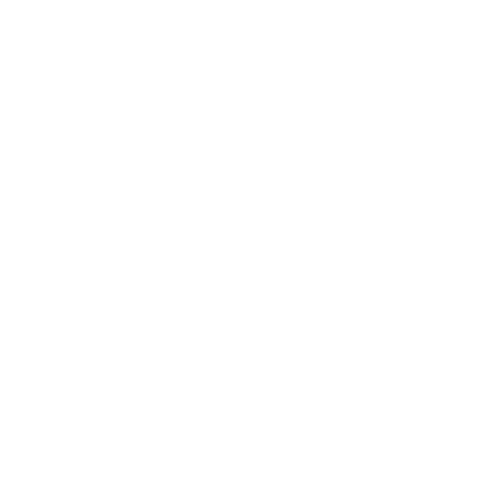

In [12]:
# Plot segment and coordinate system
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0, 0, 1, 1], projection='3d') 
# ax.axis("off")
ngain = 0.1
# Anatomical markers
# Shank
ax.plot([rhee[0],rmt1[0],rmt2[0],rmt5[0]],
        [rhee[2],rmt1[2],rmt2[2],rmt5[2]],
        [rhee[1],rmt1[1],rmt2[1],rmt5[1]],
       'ko',fillstyle='full',label='Anatomical markers')
# Foot
ax.plot([rhfi[0],rtti[0],rlml[0],rmml[0]],
        [rhfi[2],rtti[2],rlml[2],rmml[2]],
        [rhfi[1],rtti[1],rlml[1],rmml[1]],
       'ko',fillstyle='full',label='Anatomical markers')
# Technical markers
# AJC
ax.plot([rajc[0]],[rajc[2]],[rajc[1]],'ro',linewidth = 1,markersize=8,
        fillstyle='full',label='AJC')

# IOR reference frame
# Shank
ax.plot([rajc[0],rajc[0]+shankCAST[0,0]*ngain],[rajc[2],rajc[2]+shankCAST[0,2]*ngain],
        [rajc[1],rajc[1]+shankCAST[0,1]*ngain],linewidth = 1, color = 'red')
ax.plot([rajc[0],rajc[0]+shankCAST[1,0]*ngain],[rajc[2],rajc[2]+shankCAST[1,2]*ngain],
        [rajc[1],rajc[1]+shankCAST[1,1]*ngain],linewidth = 1, color = 'green')
ax.plot([rajc[0],rajc[0]+shankCAST[2,0]*ngain],[rajc[2],rajc[2]+shankCAST[2,2]*ngain],
        [rajc[1],rajc[1]+shankCAST[2,1]*ngain],linewidth = 1, color = 'blue')

# Foot
ax.plot([rhee[0],rhee[0]+footCSstatic[0,0]*ngain],[rhee[2],rhee[2]+footCSstatic[0,2]*ngain],
        [rhee[1],rhee[1]+footCSstatic[0,1]*ngain],linewidth = 1, color = 'red')
ax.plot([rhee[0],rhee[0]+footCSstatic[1,0]*ngain],[rhee[2],rhee[2]+footCSstatic[1,2]*ngain],
        [rhee[1],rhee[1]+footCSstatic[1,1]*ngain],linewidth = 1, color = 'green')
ax.plot([rhee[0],rhee[0]+footCSstatic[2,0]*ngain],[rhee[2],rhee[2]+footCSstatic[2,2]*ngain],
        [rhee[1],rhee[1]+footCSstatic[2,1]*ngain],linewidth = 1, color = 'blue')

ax.axis('equal')
ax.invert_yaxis()
#ax.set_xlim3d(500, 1000)
#ax.set_ylim3d(1000, 1500)
#ax.set_zlim3d(0, 1200)
            
ax.set_xlabel('X [mm]')
ax.set_ylabel('Z [mm]')
ax.set_zlabel('Y [mm]')

ax.legend(frameon=True, loc='best', fontsize=12, numpoints=1)
#ax.view_init
plt.show()

## Read dynamic data files

In [13]:
# read column labels
nameW = subj + trial + 'Cmkr.txt'
fnameWmkr = os.path.join(fileDir, nameW)
dfW = pd.read_csv(fnameWmkr, sep='\t', header='infer', skiprows=0, index_col=0, engine='c')

### Interpolation

In [14]:
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

In [15]:
markerLabelsWalk = dfW.columns.tolist()

### Downsampling

De modo a garantir que todas as variáveis tenham o mesmo tamanho, será feito nos passos a seguir um "Downsampling" nas variáveis com tamanhos maiores. No caso do banco de dados disponibilizado publicamente, as variáveis contidas no arquivo de forças apresentam comprimentos maiores, necessitando reduzir. Para tal, foi utilizado o comando "signal.decimate".

### Forces

In [16]:
# read column labels
nameWgrf = subj + trial + 'Cgrf.txt'
fnameWgrf = os.path.join(fileDir, nameWgrf)
dfGRF = pd.read_csv(fnameWgrf, sep='\t', header='infer', skiprows=0, index_col=0, engine='c')

In [17]:
dfGRF = dfGRF[fplat]
grfLabelsWalk = dfGRF.columns.tolist()
grf = dfGRF[fplat].values

for igrf, grfLabel in enumerate(grfLabelsWalk):
    dfW[grfLabel] = signal.decimate(dfGRF[grfLabel], 2)

In [18]:
dfGRF = dfW
labelList = dfGRF.columns.tolist()

### Low-pass Butterworth filter

Para filtrar os dados das marcas, foi utilizado um filtro Butterworth:

In [19]:
freq = 150
# Butterworth filter
b, a = butter(2, (10/(freq/2)))
for col,mkrLabel in enumerate(labelList):
    dfGRF[mkrLabel] = filtfilt(b, a, dfGRF[mkrLabel])

### Static and Dynamic markers

Foram lidas todas as marcas (dos arquivos estático e dos arquivos referentes ao andar) da perna. Posteriormente, todas marcas de ambos os arquivos foram convertidas para metros, respeitando o SI.

In [20]:
shankMarkersstatic = dfS[['R.HFX', 'R.HFY', 'R.HFZ', 'R.TTX', 'R.TTY', 'R.TTZ', 
                     'R.KneeX', 'R.KneeY', 'R.KneeZ','R.AnkleX', 'R.AnkleY', 'R.AnkleZ']]
shankMarkerswalk = dfGRF[['R.HFX', 'R.HFY', 'R.HFZ', 'R.TTX', 'R.TTY', 'R.TTZ', 
                     'R.KneeX', 'R.KneeY', 'R.KneeZ', 'R.AnkleX', 'R.AnkleY', 'R.AnkleZ']]

# Convert to meters
shankMarkersstatic = shankMarkersstatic/1000
shankMarkerswalk = shankMarkerswalk/1000

De forma análoga ao que foi feito anteriormente, o mesmo procedimento foi realizado para o segmento pé, tanto a leitura dos arquivos quanto a conversão para metros.

In [21]:
footMarkersstatic = dfS[['R.HeelX', 'R.HeelY', 'R.HeelZ', 'R.MT1X', 'R.MT1Y', 'R.MT1Z', 
                    'R.MT5X', 'R.MT5Y', 'R.MT5Z']]
footMarkerswalk = dfGRF[['R.HeelX', 'R.HeelY', 'R.HeelZ', 'R.MT1X', 'R.MT1Y', 'R.MT1Z', 
                    'R.MT5X', 'R.MT5Y', 'R.MT5Z']]

# Convert to meters
footMarkersstatic = footMarkersstatic/1000
footMarkerswalk = footMarkerswalk/1000

### Transform anatomical markers

In [22]:
def svdt(A, B, order='col'):
    """Calculates the transformation between two coordinate systems using SVD.
    This function determines the rotation matrix (R) and the translation vector
    (L) for a rigid body after the following transformation [1]_, [2]_:
    B = R*A + L + err.
    Where A and B represents the rigid body in different instants and err is an
    aleatory noise (which should be zero for a perfect rigid body). A and B are
    matrices with the marker coordinates at different instants (at least three
    non-collinear markers are necessary to determine the 3D transformation).
    The matrix A can be thought to represent a local coordinate system (but A
    it's not a basis) and matrix B the global coordinate system. The operation
    Pg = R*Pl + L calculates the coordinates of the point Pl (expressed in the
    local coordinate system) in the global coordinate system (Pg).
    A typical use of the svdt function is to calculate the transformation
    between A and B (B = R*A + L), where A is the matrix with the markers data
    in one instant (the calibration or static trial) and B is the matrix with
    the markers data for one or more instants (the dynamic trial).
    If the parameter order='row', the A and B parameters should have the shape
    (n, 3), i.e., n rows and 3 columns, where n is the number of markers.
    If order='col', A can be a 1D array with the shape (n*3, like
    [x1, y1, z1, ..., xn, yn, zn] and B a 1D array with the same structure of A
    or a 2D array with the shape (ni, n*3) where ni is the number of instants.
    The output R has the shape (ni, 3, 3), L has the shape (ni, 3), and RMSE
    has the shape (ni,). If ni is equal to one, the outputs will have the
    singleton dimension dropped.
    Part of this code is based on the programs written by Alberto Leardini,
    Christoph Reinschmidt, and Ton van den Bogert.
    Parameters
    ----------
    A   : Numpy array
        Coordinates [x,y,z] of at least three markers with two possible shapes:
        order='row': 2D array (n, 3), where n is the number of markers.
        order='col': 1D array (3*nmarkers,) like [x1, y1, z1, ..., xn, yn, zn].
    B   : 2D Numpy array
        Coordinates [x,y,z] of at least three markers with two possible shapes:
        order='row': 2D array (n, 3), where n is the number of markers.
        order='col': 2D array (ni, n*3), where ni is the number of instants.
        If ni=1, B is a 1D array like A.
    order : string
        'col': specifies that A and B are column oriented (default).
        'row': specifies that A and B are row oriented.
    Returns
    -------
    R   : Numpy array
        Rotation matrix between A and B with two possible shapes:
        order='row': (3, 3).
        order='col': (ni, 3, 3), where ni is the number of instants.
        If ni=1, R will have the singleton dimension dropped.
    L   : Numpy array
        Translation vector between A and B with two possible shapes:
        order='row': (3,) if order = 'row'.
        order='col': (ni, 3), where ni is the number of instants.
        If ni=1, L will have the singleton dimension dropped.
    RMSE : array
        Root-mean-squared error for the rigid body model: B = R*A + L + err
        with two possible shapes:
        order='row': (1,).
        order='col': (ni,), where ni is the number of instants.
    See Also
    --------
    numpy.linalg.svd
    Notes
    -----
    The singular value decomposition (SVD) algorithm decomposes a matrix M
    (which represents a general transformation between two coordinate systems)
    into three simple transformations [3]_: a rotation Vt, a scaling factor S
    along the  rotated axes and a second rotation U: M = U*S*Vt.
    The rotation matrix is given by: R = U*Vt.
    References
    ----------
    .. [1] Soderkvist, Kedin (1993) Journal of Biomechanics, 26, 1473-1477.
    .. [2] http://www.kwon3d.com/theory/jkinem/rotmat.html.
    .. [3] http://en.wikipedia.org/wiki/Singular_value_decomposition.
    Examples
    --------
    >>> import numpy as np
    >>> from svdt import svdt
    >>> A = np.array([0,0,0, 1,0,0,  0,1,0,  1,1,0])  # four markers
    >>> B = np.array([0,0,0, 0,1,0, -1,0,0, -1,1,0])  # four markers
    >>> R, L, RMSE = svdt(A, B)
    >>> B = np.vstack((B, B))  # simulate two instants (two rows)
    >>> R, L, RMSE = svdt(A, B)
    >>> A = np.array([[0,0,0], [1,0,0], [ 0,1,0], [ 1,1,0]])  # four markers
    >>> B = np.array([[0,0,0], [0,1,0], [-1,0,0], [-1,1,0]])  # four markers
    >>> R, L, RMSE = svdt(A, B, order='row')
    """

    A, B = np.asarray(A), np.asarray(B)
    if order == 'row' or B.ndim == 1:
        if B.ndim == 1:
            A = A.reshape(int(A.size/3), 3)
            B = B.reshape(int(B.size/3), 3)
        R, L, RMSE = svd(A, B)
    else:
        A = A.reshape(int(A.size/3), 3)
        ni = B.shape[0]
        R = np.empty((ni, 3, 3))
        L = np.empty((ni, 3))
        RMSE = np.empty(ni)
        for i in range(ni):
            R[i, :, :], L[i, :], RMSE[i] = svd(A, B[i, :].reshape(A.shape))

    return R, L, RMSE

In [23]:
def svd(A, B):
    """Calculates the transformation between two coordinate systems using SVD.
    See the help of the svdt function.
    Parameters
    ----------
    A   : 2D Numpy array (n, 3), where n is the number of markers.
        Coordinates [x,y,z] of at least three markers
    B   : 2D Numpy array (n, 3), where n is the number of markers.
        Coordinates [x,y,z] of at least three markers
    Returns
    -------
    R    : 2D Numpy array (3, 3)
         Rotation matrix between A and B
    L    : 1D Numpy array (3,)
         Translation vector between A and B
    RMSE : float
         Root-mean-squared error for the rigid body model: B = R*A + L + err.
    See Also
    --------
    numpy.linalg.svd
    """

    Am = np.mean(A, axis=0)           # centroid of m1
    Bm = np.mean(B, axis=0)           # centroid of m2
    M = np.dot((B - Bm).T, (A - Am))  # considering only rotation
    # singular value decomposition
    U, S, Vt = np.linalg.svd(M)
    # rotation matrix
    R = np.dot(U, np.dot(np.diag([1, 1, np.linalg.det(np.dot(U, Vt))]), Vt))
    # translation vector
    L = B.mean(0)  - np.dot(R, A.mean(0))
    # RMSE
    err = 0
    for i in range(A.shape[0]):
        Bp = np.dot(R, A[i, :]) + L
        err += np.sum((Bp - B[i, :])**2)
    RMSE = np.sqrt(err/A.shape[0]/3)

    return R, L, RMSE

In [24]:
# Calculating the translation and rotation matrix
# from svdt import svdt
Rshank, Lshank, RMSE = svdt(shankMarkersstatic.values.mean(axis=0), shankMarkerswalk.values)
Rfoot, Lfoot, RMSE = svdt(footMarkersstatic.values.mean(axis=0), footMarkerswalk.values)

In [25]:
# shank markers
rknlw = shankMarkerswalk[['R.KneeX', 'R.KneeY', 'R.KneeZ']].values
rknmw = np.dot(Rshank,rknm) + Lshank
rhfiw = shankMarkerswalk[['R.HFX', 'R.HFY', 'R.HFZ']].values
rttiw = shankMarkerswalk[['R.TTX', 'R.TTY', 'R.TTZ']].values
rlmlw = shankMarkerswalk[['R.AnkleX', 'R.AnkleY', 'R.AnkleZ']].values
rmmlw = np.dot(Rshank,rmml) + Lshank
rkjcw = (rknlw+rknmw)/2
rajcw = (rlmlw+rmmlw)/2

In [26]:
# foot markers
rheew = footMarkerswalk[['R.HeelX', 'R.HeelY', 'R.HeelZ']].values
rmt1w = footMarkerswalk[['R.MT1X', 'R.MT1Y', 'R.MT1Z']].values
rmt2w = np.dot(Rfoot,rmt2) + Lfoot
rmt5w = footMarkerswalk[['R.MT5X', 'R.MT5Y', 'R.MT5Z']].values

## Segment reference system during walking

In [27]:
shankCSwalk= np.empty(shape=(len(rheew),3,3))
footCSwalk = np.empty(shape=(len(rheew),3,3))
for ix in range(rheew.shape[0]):
    shankCSwalk[ix,:,:] = shankIOR(rhfiw[ix,:],rttiw[ix,:],rlmlw[ix,:],rajcw[ix,:])
    footCSwalk[ix,:,:]  = footIOR(rheew[ix,:],rmt1w[ix,:],rmt2w[ix,:],rmt5w[ix,:])

After finding the virtual tags...

#### Markers positions

A nomenclatura utilizada anteriormente para as marcas foi substituída pela utilizada por Leardini et al. [1]

In [28]:
LM = rlmlw
MM = rmmlw
VM = rmt5w
FM = rmt1w
CA = rheew
HF = rhfiw
TT = rttiw

## Basis

#### Foot

In [29]:
v1_foot = MM - LM
e1_foot2 = v1_foot/np.linalg.norm(v1_foot, axis=1, keepdims=True)
v2_foot = (VM + FM)/2 - CA
v3_foot = np.cross(v1_foot, v2_foot, axis=1)
e3_foot2 = v3_foot/np.linalg.norm(v3_foot, axis=1, keepdims=True)
v3_foot = np.squeeze(v3_foot)
v2_foot = np.cross(v3_foot, v1_foot, axis=1)
e2_foot2 = v2_foot/np.linalg.norm(v2_foot,axis=1,keepdims=True)
v2_foot = np.squeeze(v2_foot)

In [30]:
e3_foot = footCSwalk[:,2,:]
e2_foot = footCSwalk[:,1,:]
e1_foot = footCSwalk[:,0,:]

#### Shank

In [31]:
v1_shank = MM - LM
e1_shank2 = v1_shank/np.linalg.norm(v1_shank, axis=1, keepdims=True)
v2_shank = (MM + LM)/2 - (HF+TT)/2
v3_shank = np.cross(v1_shank, v2_shank, axis=1)
e3_shank2 = v3_shank/np.linalg.norm(v3_shank, axis=1, keepdims=True)
v3_shank = np.squeeze(v3_shank)
v2_shank = np.cross(v3_shank, v1_shank, axis=1)
e2_shank2 = v2_shank/np.linalg.norm(v2_shank,axis=1,keepdims=True)
v2_shank = np.squeeze(v2_shank)

In [32]:
e3_shank = shankCSwalk[:,2,:]
e2_shank = shankCSwalk[:,1,:]
e1_shank = shankCSwalk[:,0,:]

## Angular acceleration

#### Foot

In [33]:
de1dt_foot = (e1_foot[2:,:]-e1_foot[0:-2,:])/(2*dt)
de2dt_foot = (e2_foot[2:,:]-e2_foot[0:-2,:])/(2*dt)
de3dt_foot = (e3_foot[2:,:]-e3_foot[0:-2,:])/(2*dt)

omega_footFoot = np.hstack((np.sum(de2dt_foot*e3_foot[1:-1,:], axis = 1).reshape(-1,1), 
                        np.sum(de3dt_foot*e1_foot[1:-1,:], axis = 1).reshape(-1,1), 
                        np.sum(de1dt_foot*e2_foot[1:-1,:], axis = 1).reshape(-1,1)))
omega_footFoot = np.vstack((omega_footFoot, omega_footFoot[-1, :], omega_footFoot[-1, :]))

In [34]:
omega_footGlobal = np.zeros_like(omega_footFoot)
for i in range(omega_footFoot.shape[0]):
    RGLomega_foot = np.vstack((e1_foot[i,:],e2_foot[i,:],e3_foot[i,:]))
    omega_footGlobal[i,:]=RGLomega_foot.T@omega_footFoot[i,:] #A transposta faz com que seja da coordenada local p/ global


#### Shank

In [35]:
de1dt_shank = (e1_shank[2:,:]-e1_shank[0:-2,:])/(2*dt)
de2dt_shank = (e2_shank[2:,:]-e2_shank[0:-2,:])/(2*dt)
de3dt_shank = (e3_shank[2:,:]-e3_shank[0:-2,:])/(2*dt)

omega_shankShank = np.hstack((np.sum(de2dt_shank*e3_shank[1:-1,:], axis = 1).reshape(-1,1), 
                         np.sum(de3dt_shank*e1_shank[1:-1,:], axis = 1).reshape(-1,1), 
                         np.sum(de1dt_shank*e2_shank[1:-1,:], axis = 1).reshape(-1,1)))
omega_shankShank = np.vstack((omega_shankShank, omega_shankShank[-1, :], omega_shankShank[-1, :]))

In [36]:
omega_shankGlobal = np.zeros_like(omega_shankShank)
for i in range(omega_shankShank.shape[0]):
    RGLomega_shank = np.vstack((e1_shank[i,:],e2_shank[i,:],e3_shank[i,:]))
    omega_shankGlobal[i,:]=RGLomega_shank.T@omega_shankShank[i,:] #A transposta faz com que seja da coordenada local p/ global

## Center of mass

Creating a plane:

In [37]:
a = HF - LM
b = LM - MM
n = np.cross(a, b, axis=1)
n_norm = n/np.linalg.norm(n, axis=1, keepdims=True)

Finding the distance between TT and the TTp:

In [38]:
d = np.sum((TT-LM)*n_norm,axis=1, keepdims=True)
TTp = TT - (d*n_norm)

Testing (Must be zero):

In [39]:
Test =np.sum((HF - TTp)*n_norm, axis=1)
Test

array([ 3.98986399e-17,  1.04083409e-17, -2.94902991e-17, -1.73472348e-18,
       -1.73472348e-18,  1.21430643e-17, -1.73472348e-18, -5.20417043e-18,
        0.00000000e+00, -5.20417043e-18, -2.25514052e-17,  1.73472348e-17,
        6.93889390e-18,  6.93889390e-18, -3.46944695e-18,  1.04083409e-17,
       -2.08166817e-17,  6.93889390e-18,  2.42861287e-17,  1.73472348e-17,
       -6.93889390e-18,  3.46944695e-18, -6.93889390e-18,  3.46944695e-18,
       -2.08166817e-17, -4.16333634e-17, -2.42861287e-17,  1.04083409e-17,
       -3.46944695e-18, -2.77555756e-17,  3.46944695e-18,  1.04083409e-17,
        0.00000000e+00,  2.08166817e-17,  1.73472348e-17, -3.46944695e-18,
        1.04083409e-17, -3.46944695e-18, -2.77555756e-17, -3.46944695e-18,
        2.08166817e-17,  1.73472348e-18, -1.38777878e-17,  2.42861287e-17,
       -3.46944695e-18,  1.04083409e-17, -1.90819582e-17, -3.29597460e-17,
        2.25514052e-17,  0.00000000e+00,  1.04083409e-17, -2.77555756e-17,
       -3.29597460e-17,  

Segments positions:

In [40]:
r_foot_prox = CA
r_foot_dis = (VM+FM)/2
r_shank_prox = TTp
r_shank_dis =(MM+LM)/2

The position of the center of mass of each segment:

In [41]:
# BSP male values from Zatsiorsky's model adjusted by de Leva (1996)
rcm_foot  = r_foot_prox + 0.4415*(r_foot_dis-r_foot_prox)
rcm_shank  = r_shank_prox + 0.4395*(r_shank_dis-r_shank_prox)

The velocity of the center of mass of each segment:

In [42]:
vcm_foot = (rcm_foot[2:,:]-rcm_foot[0:-2,:])/(2*dt)
vcm_foot = np.vstack((vcm_foot, vcm_foot[-1, :], vcm_foot[-1, :]))
vcm_shank = (rcm_shank[2:,:]-rcm_shank[0:-2,:])/(2*dt)
vcm_shank = np.vstack((vcm_shank, vcm_shank[-1, :], vcm_shank[-1, :]))

The acceleration of the center of mass of each segment:

In [43]:
acm_foot = (vcm_foot[2:,:]-vcm_foot[0:-2,:])/(2*dt)
acm_foot = np.vstack((acm_foot, acm_foot[-1, :], acm_foot[-1, :]))
acm_shank = (vcm_shank[2:,:]-vcm_shank[0:-2,:])/(2*dt)
acm_shank = np.vstack((acm_shank, acm_shank[-1, :], acm_shank[-1, :]))

## Displacement of the COP with respect to the UD segment’s COM

In [44]:
cop_position = dfGRF[['COPx4','COPy4','COPz4']].values/1000

In [45]:
rUD_cop_aux = cop_position - rcm_shank
rUD_cop = rUD_cop_aux[0:len(omega_shankGlobal)]              

## Total deformation velocity of the distal component

In [46]:
VUDd = vcm_shank + np.cross(omega_shankGlobal, rUD_cop)

## Total distal power of the UD segment

In [47]:
aux6 = dfGRF['Ty4'].values/1000
aux7 = (len(aux6),3)
aux7  = np.zeros(aux7 )
aux7 [:,1] = aux6
Mfree = aux7 

Fgrf = dfGRF[['Fx4','Fy4','Fz4']].values

In [48]:
aux4 = np.sum(Fgrf[0:len(VUDd)]*VUDd, axis=1)
aux5 = np.sum(Mfree[0:len(omega_shankGlobal)]*omega_shankGlobal, axis=1)
PUD = aux4 + aux5

<IPython.core.display.Javascript object>


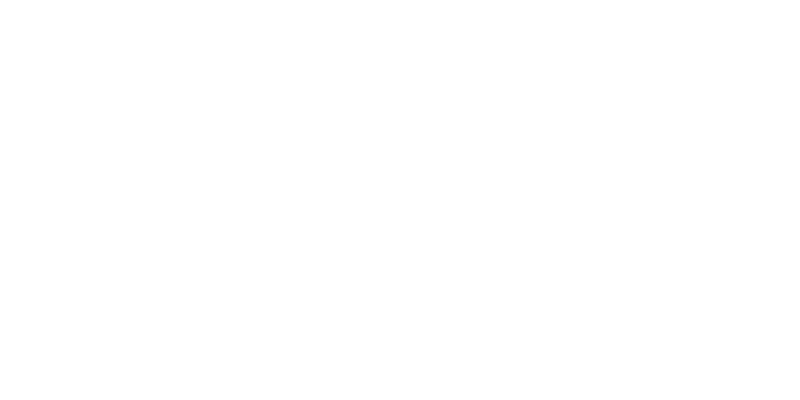

In [49]:
from detect_onset import detect_onset
inds = detect_onset(Fgrf[:,1], 30, n_above=10, n_below=0, show=True)

<IPython.core.display.Javascript object>


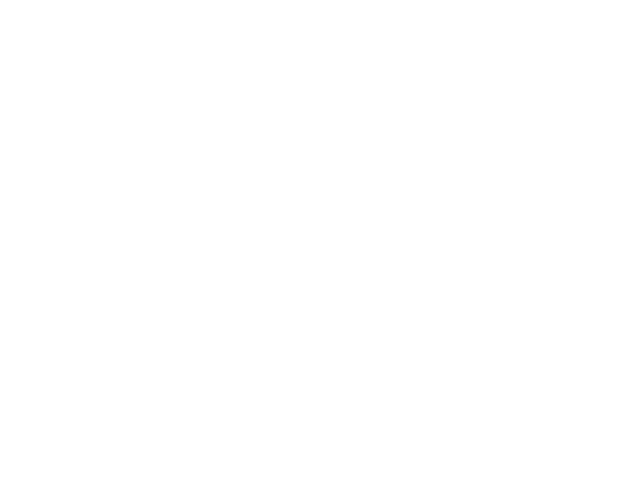

In [50]:
plt.figure()
plt.title('Takahashi - UD')
plt.plot(PUD/M)
plt.show()
plt.grid()

## Inverse dynamics

#### Segment mass

In [51]:
# BSP male values from Zatsiorsky's model adjusted by de Leva (1996)
m_foot = M*0.0137
m_shank = M*0.0433

#### Moment of inertia of the segments

In [52]:
# BSP male values from Zatsiorsky's model adjusted by de Leva (1996)
I1_foot = m_foot*((0.257*(np.mean(np.linalg.norm(r_foot_dis-r_foot_prox, axis=1)))**2)) #Sag 
I2_foot = m_foot*((0.124*(np.mean(np.linalg.norm(r_foot_dis-r_foot_prox, axis=1)))**2))#Long 
I3_foot = m_foot*((0.245*(np.mean(np.linalg.norm(r_foot_dis-r_foot_prox, axis=1)))**2))#Trans
I1_shank = m_shank*((0.251*(np.mean(np.linalg.norm(r_shank_dis-r_shank_prox, axis=1)))**2))#Sag
I2_shank = m_shank*((0.102*(np.mean(np.linalg.norm(r_shank_dis-r_shank_prox, axis=1)))**2))#Long
I3_shank = m_shank*((0.246*(np.mean(np.linalg.norm(r_shank_dis-r_shank_prox, axis=1)))**2))#Trans

#### Segments angular acceleration

In [53]:
alpha_footGlobal = (omega_footGlobal[2:,:]-omega_footGlobal[0:-2,:])/(2*dt) #Global
alpha_footGlobal = np.vstack((alpha_footGlobal, alpha_footGlobal[-1, :], alpha_footGlobal[-1, :]))
alpha_shankGlobal = (omega_shankGlobal[2:,:]-omega_shankGlobal[0:-2,:])/(2*dt) #Global
alpha_shankGlobal = np.vstack((alpha_shankGlobal, alpha_shankGlobal[-1, :], alpha_shankGlobal[-1, :]))

### Forces

##### Foot

In [54]:
g = 9.80665  # m/s2, standard acceleration of free fall (ISO 80000-3:2006)
Fgrf = Fgrf[0:len(acm_foot)]

Fx_foot = m_foot*acm_foot[:,0] - Fgrf[:,0]
Fy_foot = m_foot*acm_foot[:,1] - Fgrf[:,1]
Fz_foot = m_foot*acm_foot[:,2] - Fgrf[:,2] + m_foot*g 
F_ankle=np.hstack((Fx_foot.reshape(-1,1),Fy_foot.reshape(-1,1),Fz_foot.reshape(-1,1)))

##### Shank

In [55]:
Fx_shank = m_shank*acm_shank[:,0] + F_ankle[:,0]
Fy_shank = m_shank*acm_shank[:,1] + F_ankle[:,1] 
Fz_shank = m_shank*acm_shank[:,2] + F_ankle[:,2] + m_shank*g
F_knee=np.hstack((Fx_shank.reshape(-1,1),Fy_shank.reshape(-1,1),Fz_shank.reshape(-1,1)))

### Moments

Para garantir que as equações dos torques fossem feitas na coordenada correta, as acelerações angulares do pé e da perna, assim como o momento livre receberam uma matrix de rotação para a base local.

In [56]:
#Foot
alpha_footFoot = np.zeros_like(alpha_footGlobal)
for i in range(alpha_footGlobal.shape[0]):
    RLGalpha_foot = np.vstack((e1_foot[i,:],e2_foot[i,:],e3_foot[i,:]))
    alpha_footFoot[i,:]=RLGalpha_foot@alpha_footGlobal[i,:]
    

#Shank
alpha_shankShank = np.zeros_like(alpha_shankGlobal)
for i in range(alpha_shankGlobal.shape[0]):
    RLGalpha_shank = np.vstack((e1_shank[i,:],e2_shank[i,:],e3_shank[i,:]))
    alpha_shankShank[i,:]=RLGalpha_shank@alpha_shankGlobal[i,:]

#Free Moment
MfreeFoot = np.zeros_like(Mfree)
for i in range(Mfree.shape[0]):
    RLGMfree = np.vstack((e1_foot[i,:],e2_foot[i,:],e3_foot[i,:]))
    MfreeFoot[i,:]=RLGMfree@Mfree[i,:]

##### Foot

Com as matrizes de rptação criadas, foram computados 2 dos 3 torques no segmento pé. O primeiro deles foi o torque referente ao produto vetorial da distância do tornozelo até o centro de massa pela força no tornozelo (MF_anklefootGlobal). O segundo foi o torque referente ao produto vetorial da distância do centro de pressão até o centro de pressão pela força de reação do solo (MF_grfGlobal). Ambos os torques estavam na coordenada global, e também foram obtidos para a coordenada local por meio de uma matriz de rotação (MF_anklefootFoot e MF_grfFoot).

In [57]:
# M_ankle = "I*alpha" - (rp -rcm) X Força no tornozeo - (rd - rcm) X força de reação do solo - Momento livre
MF_anklefootGlobal = np.cross(r_shank_dis[0:len(F_ankle)] - rcm_foot[0:len(F_ankle)], F_ankle)
MF_grfGlobal = np.cross(cop_position[0:len(Fgrf)] - rcm_foot[0:len(Fgrf)], Fgrf)
# Rotation matrix to the local basis
MF_grfFoot = np.zeros_like(MF_grfGlobal)
MF_anklefootFoot = np.zeros_like(MF_grfGlobal)
for i in range(MF_grfGlobal.shape[0]):
    RLGMF_grf = np.vstack((e1_foot[i,:],e2_foot[i,:],e3_foot[i,:]))
    MF_grfFoot[i,:]=RLGMF_grf@MF_grfGlobal[i,:]
    MF_anklefootFoot[i,:]=RLGMF_grf@MF_anklefootGlobal[i,:]

Para obter o torque no tornozelo, foi utilizada a segunda lei Newton-Euler, que fez uso também do momento livre e do momento de inércia do pé, obtido anteriormente.

<IPython.core.display.Javascript object>


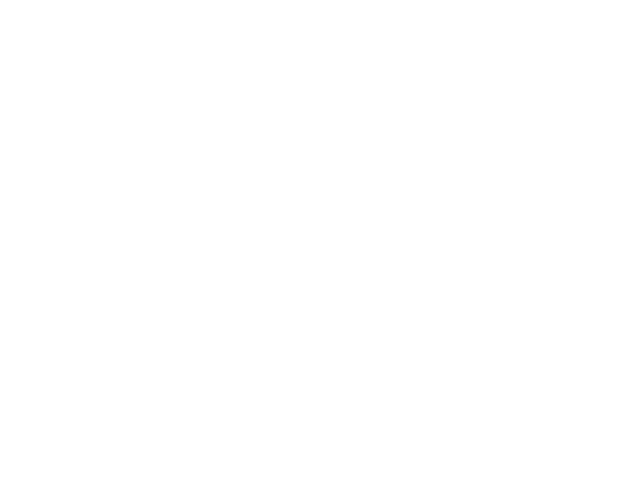

<IPython.core.display.Javascript object>


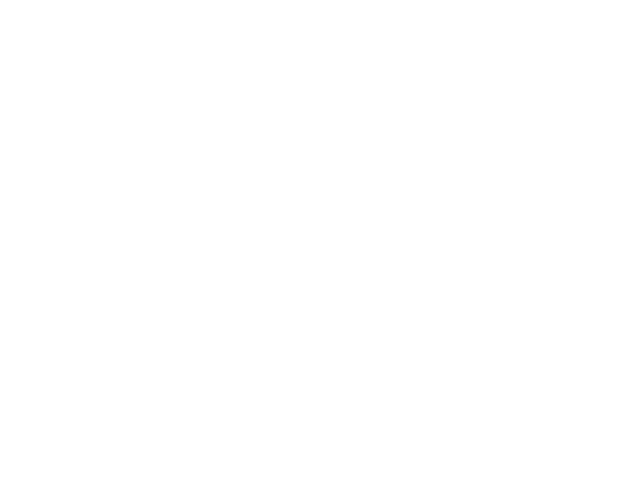

In [58]:
# M_ankle = "I*alpha" - (rp -rcm) X Força no tornozeo - (rd - rcm) X força de reação do solo - Momento livre
I_foot = np.array([[I1_foot,0,0],[0,I2_foot,0],[0,0,I3_foot]])
M_ankleFoot = (I_foot@alpha_footFoot.T).T  + np.cross(omega_footFoot[0:alpha_footFoot.shape[0],:], (I_foot@omega_footFoot[0:alpha_footFoot.shape[0],:].T).T,axis=1) - MF_anklefootFoot - MF_grfFoot - MfreeFoot[0:len(MF_anklefootFoot)]

plt.figure()
plt.plot(M_ankleFoot)
plt.legend(('e1','e2','e3'))
plt.title('Ankle Torque')
plt.ylabel('M (N.m)')
plt.grid()

plt.figure()
plt.plot(F_ankle)
plt.title('Ankle Force')
plt.legend(('X','Y','Z'))
plt.ylabel('F (N)')
plt.grid()
plt.show()

#### Shank

Computing the moments:

In [59]:
# M_knee = "I*alpha" + M_ankle + (rd -rcm) X Força do tornozelo - (rp - rcm) X Forças na perna
MF_kneeshankGlobal = np.cross(r_shank_prox[0:len(F_knee)] - rcm_shank[0:len(F_knee)], F_knee) #from shank
MF_ankleshankGlobal = np.cross(r_shank_dis[0:len(F_ankle)] - rcm_shank[0:len(F_ankle)], F_ankle)   #from foot

# Rotation matrix to the local basis
MF_kneeshankShank = np.zeros_like(MF_ankleshankGlobal)
MF_ankleshankShank = np.zeros_like(MF_ankleshankGlobal)
M_ankleShank = np.zeros_like(M_ankleFoot)

for i in range(MF_ankleshankGlobal.shape[0]):
    RLGMF_ankle = np.vstack((e1_shank[i,:],e2_shank[i,:],e3_shank[i,:]))
    RLGMF_foot = np.vstack((e1_foot[i,:],e2_foot[i,:],e3_foot[i,:]))
    MF_kneeshankShank[i,:]=RLGMF_ankle@MF_kneeshankGlobal[i,:]
    MF_ankleshankShank[i,:]=RLGMF_ankle@MF_ankleshankGlobal[i,:]
    M_ankleShank[i,:] = RLGMF_ankle@RLGMF_foot.T@M_ankleFoot[i,:]

Second Newton-Euler law to obtain the knee moment:

<IPython.core.display.Javascript object>


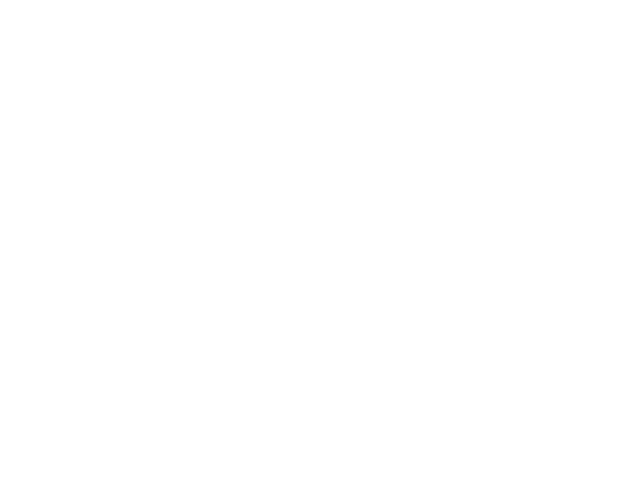

<IPython.core.display.Javascript object>


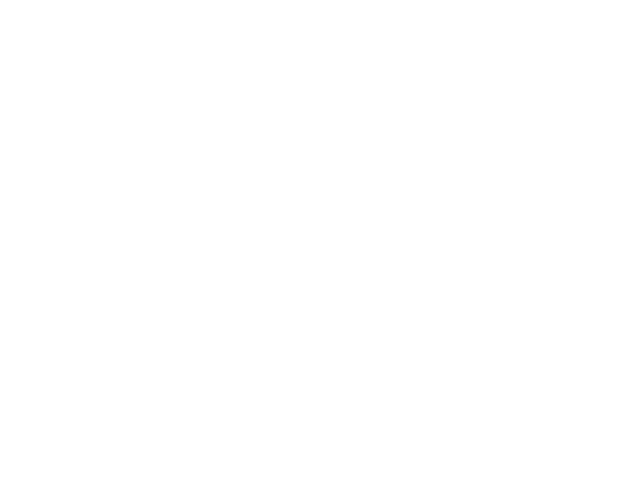

In [60]:
# M_knee = "I*alpha" + M_knee + (rd -rcm) X Força do tornozelo - (rp - rcm) X Forças na perna
I_shank = np.array([[I1_shank,0,0],[0,I2_shank,0],[0,0,I3_shank]])
M_kneeShank = (I_shank@alpha_shankShank.T).T  + np.cross(omega_shankShank[0:alpha_shankShank.shape[0],:], (I_shank@omega_shankShank[0:alpha_shankShank.shape[0],:].T).T,axis=1) - MF_kneeshankShank + MF_ankleshankShank + M_ankleShank

plt.figure()
plt.plot(M_kneeShank)
plt.legend(('e1','e2','e3'))
plt.title('Knee Torque')
plt.ylabel('M (N.m)')
plt.grid()

plt.figure()
plt.plot(F_knee)
plt.title('Knee Force')
plt.legend(('X','Y','Z'))
plt.ylabel('F (N)')
plt.grid()
plt.show()

## Anatomically-relevant (AR) Power

The total power of these below-knee structures can be found by summing the total ankle joint power and distal foot segmental power using a deformable foot model

#### Angular Velocity

In [61]:
omega_ankleGlobal = omega_footGlobal - omega_shankGlobal

#### Transforming to the global basis

In [62]:
#M_ankleFoot
M_ankleGlobal = np.zeros_like(M_ankleFoot)
for i in range(M_ankleFoot.shape[0]):
    RGLM_ankle = np.vstack((e1_foot[i,:],e2_foot[i,:],e3_foot[i,:]))
    M_ankleGlobal[i,:]=RGLM_ankle.T@M_ankleFoot[i,:]

#### Joint Velocity

In [63]:
VcopGlobal = vcm_foot + np.cross(omega_footGlobal, cop_position[0:len(omega_footGlobal)] - rcm_foot[0:len(omega_footGlobal)])
VanklefootGlobal = vcm_foot + np.cross(omega_footGlobal, r_shank_dis[0:len(omega_footGlobal)] - rcm_foot[0:len(omega_footGlobal)])
VankleshankGlobal = vcm_shank + np.cross(omega_shankGlobal, r_shank_dis[0:len(omega_shankGlobal)] - rcm_shank[0:len(omega_shankGlobal)])
deltaVGlobal = VanklefootGlobal - VankleshankGlobal

#### Power (Pank)

In [64]:
Pank = np.sum(M_ankleGlobal[0:len(Fgrf)]*omega_ankleGlobal[0:len(Fgrf)], axis=1) + np.sum(F_ankle[0:len(Fgrf)]*deltaVGlobal[0:len(Fgrf)], axis=1)

#### Power (Pftd)

In [65]:
Pftd = np.sum(Fgrf*VcopGlobal[0:len(Fgrf)], axis=1) + np.sum(Mfree[0:len(Fgrf)]*omega_footGlobal[0:len(Fgrf)], axis=1)

#### Power (PAR)

In [66]:
Par = Pank + Pftd

<IPython.core.display.Javascript object>


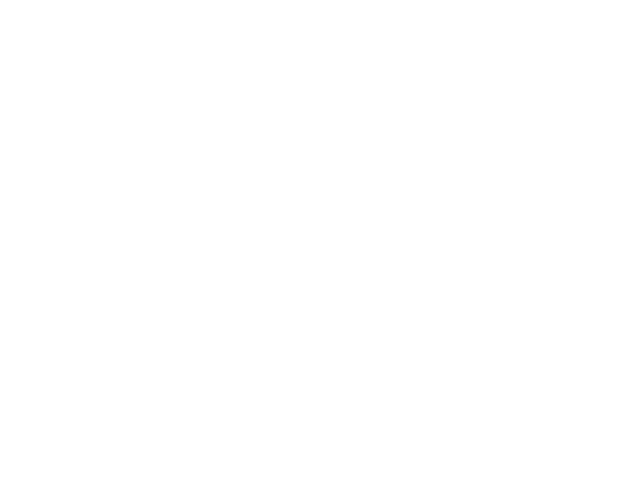

In [67]:
plt.figure()
plt.plot(Par/M)
plt.plot(Pank/M)
plt.plot(Pftd/M)
plt.legend(('$P_AR$','$P_ank$','$P_ftd$'))
plt.title(('Power'))
plt.show()
plt.grid()

<IPython.core.display.Javascript object>


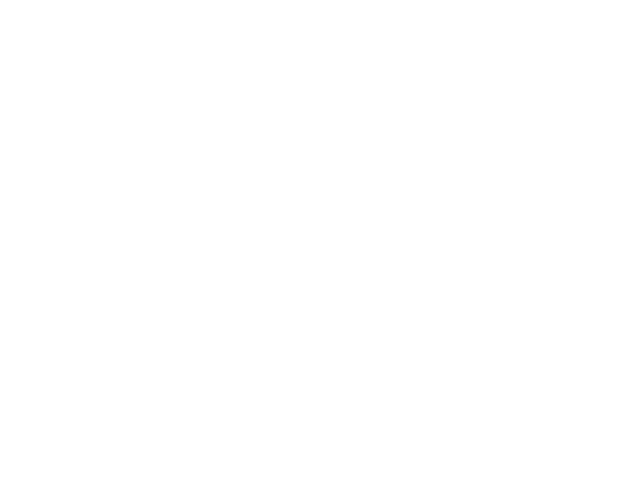

In [68]:
plt.figure()
plt.plot(Par/M)
plt.title(('Anatomically-relevant (AR) Power'))
plt.show()
plt.grid()

## Zelik Method

Anklefoot: Distal Shank Power

<IPython.core.display.Javascript object>


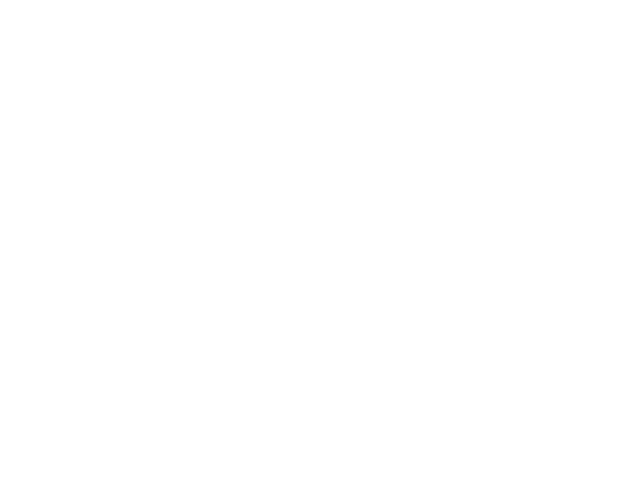

In [69]:
# Pdistal_shank_zelik = Fgrf.(Vcm_shank + omega_shank X r_cop/shank) + Mfree.omega_shank

rcp_shank_zelik = cop_position - rcm_shank
Mshank_zelik = vcm_shank + np.cross(omega_shankGlobal, rcp_shank_zelik[0:len(vcm_shank)])
Pdistal_shank_zelik = np.sum(Fgrf*Mshank_zelik[0:len(Fgrf)], axis=1) + np.sum(Mfree[0:len(Fgrf)]*omega_shankGlobal[0:len(Fgrf)], axis = 1)

plt.figure()
plt.plot(Pdistal_shank_zelik/M, color = 'green')
plt.title(('Anklefoot: Distal Shank Power (Zelik)'))
plt.show()
plt.grid()

# The Distal Shank Method (DS) - Frigo

<IPython.core.display.Javascript object>


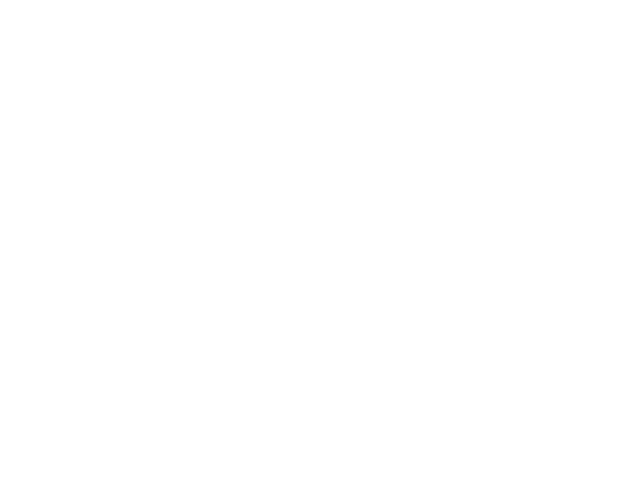

In [70]:
# Pdistal_shank_frigo = Fgrf.Vcm_sahnk + (Mgrf/shank + Mfree).Omega_shank
Mgrf_shank = np.cross(rUD_cop[0:len(Fgrf)], Fgrf)
Pdistal_shank_frigo = np.sum(Fgrf*vcm_shank[0:len(Fgrf)], axis=1) + np.sum((Mgrf_shank + Mfree[0:len(Fgrf)])*omega_shankGlobal[0:len(Fgrf)], axis=1)

plt.figure()
plt.plot(Pdistal_shank_frigo/M, color = 'red')
plt.title(('Power - Frigo'))
plt.show()
plt.grid()

<IPython.core.display.Javascript object>


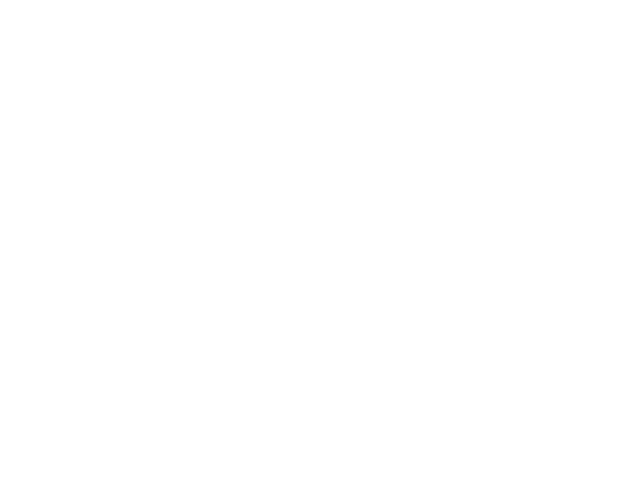

In [71]:
plt.figure()
plt.plot(Par/M)
plt.plot(PUD/M)
plt.plot(Pdistal_shank_zelik/M)
plt.plot(Pdistal_shank_frigo/M)
plt.title(('Power Comparison'))
plt.legend(('$InvDyn$','$Takahashi$','$Zelik$', '$Frigo$'))
plt.show()
plt.grid()

# Saving 

### Comparison between methods and groups

grf_vertical = Fgrf[:,1]
dataWBDS = np.array([Par/M,PUD/M,Pdistal_shank_zelik/M, Pdistal_shank_frigo/M,grf_vertical])
np.savetxt('dataWBDS36_3.txt', dataWBDS.T, delimiter=',', header="InvDyn,Takahashi,Zelik,Frigo,GRF") 

### Comparison between pank, par and pftd

In [72]:
grf_vertical = Fgrf[:,1]
dataWBDS2 = np.array([Pank/M,Pftd/M,Par/M, grf_vertical]) 
np.savetxt('data2WBDS36_3.txt', dataWBDS2.T, delimiter=',', header="Pank,Pftd,Par,GRF") 

# Lower extremity distal power analysis
Compare methods to calculate power and group of subjects.

In [73]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, Math, Latex
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy.integrate import simps

import sys, os
sys.path.insert(1, r'./../functions')  # add to pythonpath

import io_cortexmac as io
from critic_damp import critic_damp
from detect_onset import detect_onset

# scipy and numpy have too many future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
fileDir = r'C:\Users\ebm\Desktop\Lucas Santana\RunAge'

In [75]:
WBDS01_1 = np.genfromtxt(fname='dataWBDS01_1.txt', skip_header=1, delimiter = ',')
WBDS01_2 = np.genfromtxt(fname='dataWBDS01_2.txt', skip_header=1, delimiter = ',')
WBDS01_3 = np.genfromtxt(fname='dataWBDS01_3.txt', skip_header=1, delimiter = ',')
WBDS05_1 = np.genfromtxt(fname='dataWBDS05_1.txt', skip_header=1, delimiter = ',')
WBDS05_2 = np.genfromtxt(fname='dataWBDS05_2.txt', skip_header=1, delimiter = ',')
WBDS05_3 = np.genfromtxt(fname='dataWBDS05_3.txt', skip_header=1, delimiter = ',')
WBDS34_1 = np.genfromtxt(fname='dataWBDS34_1.txt', skip_header=1, delimiter = ',')
WBDS34_2 = np.genfromtxt(fname='dataWBDS34_2.txt', skip_header=1, delimiter = ',')
WBDS34_3 = np.genfromtxt(fname='dataWBDS34_3.txt', skip_header=1, delimiter = ',')
WBDS36_1 = np.genfromtxt(fname='dataWBDS36_1.txt', skip_header=1, delimiter = ',')
WBDS36_2 = np.genfromtxt(fname='dataWBDS36_2.txt', skip_header=1, delimiter = ',')
WBDS36_3 = np.genfromtxt(fname='dataWBDS36_3.txt', skip_header=1, delimiter = ',')

## Read data

In [76]:
from detect_onset import detect_onset
from tnorm import tnorm

In [77]:
methods = ['# InvDyn', 'Takahashi', 'Zelik', 'Frigo']
methods2 = ['# Pank', 'Pftd', 'Par']

## Young subjects

In [78]:
# Young
subjects = ['01','05']
yn3 = np.empty(shape=(101,4))
for im, method in enumerate(methods):
    yn2 = np.empty(shape=(101,len(subjects)))
    for s in range(len(subjects)):
        yn = np.empty(shape=(101,3))
        for trial in range(3):
            # read column labels
            nameS = 'dataWBDS' + subjects[s] + '_' + str(trial+1) + '.txt'
            fnameS = os.path.join(fileDir, nameS)
            dfS = pd.read_csv(fnameS, sep=',', header=0, skiprows=0, index_col=None, engine='c')
            
            # Detect events
            inds = detect_onset(dfS['GRF'], 20, n_above=10, n_below=0, show=False)
            
            xx = dfS[method].values[inds[0][0]:inds[0][1]]
            
            t  = np.linspace(0, 100, len(xx))  # time vector for the original data
            tn = np.linspace(0, 100, 101)     # new time vector for the new time-normalized data
            yn[:,trial] = np.interp(tn, t, xx)
        
        # Average across trials
        yn2[:,s] = np.nanmean(yn, axis=1)
        
    # Average across subjects
    yn3[:,im] = np.nanmean(yn2, axis=1)
    
# Young
subjects = ['01','05']
ynp3 = np.empty(shape=(101,4))
for im, method in enumerate(methods2):
    ynp2 = np.empty(shape=(101,len(subjects)))
    for s in range(len(subjects)):
        ynp = np.empty(shape=(101,3))
        for trial in range(3):
            # read column labels
            nameS = 'data2WBDS' + subjects[s] + '_' + str(trial+1) + '.txt'
            fnameS = os.path.join(fileDir, nameS)
            dfS = pd.read_csv(fnameS, sep=',', header=0, skiprows=0, index_col=None, engine='c')
            
            # Detect events
            inds = detect_onset(dfS['GRF'], 20, n_above=10, n_below=0, show=False)
            
            xx = dfS[method].values[inds[0][0]:inds[0][1]]
            
            t  = np.linspace(0, 100, len(xx))  # time vector for the original data
            tn = np.linspace(0, 100, 101)     # new time vector for the new time-normalized data
            ynp[:,trial] = np.interp(tn, t, xx)
        
        # Average across trials
        ynp2[:,s] = np.nanmean(ynp, axis=1)
        
    # Average across subjects
    ynp3[:,im] = np.nanmean(ynp2, axis=1)

## Older subjects

In [79]:
# Older
subjects = ['34','36']
on3 = np.empty(shape=(101,4))
for im, method in enumerate(methods):
    on2 = np.empty(shape=(101,len(subjects)))
    for s in range(len(subjects)):
        on = np.empty(shape=(101,3))
        for trial in range(3):
            # read column labels
            nameS = 'dataWBDS' + subjects[s] + '_' + str(trial+1) + '.txt'
            fnameS = os.path.join(fileDir, nameS)
            dfS = pd.read_csv(fnameS, sep=',', header=0, skiprows=0, index_col=None, engine='c')
            
            # Detect events
            inds = detect_onset(dfS['GRF'], 20, n_above=10, n_below=0, show=False)
            
            xx = dfS[method].values[inds[0][0]:inds[0][1]]
            
            t  = np.linspace(0, 100, len(xx))  # time vector for the original data
            tn = np.linspace(0, 100, 101)     # new time vector for the new time-normalized data
            on[:,trial] = np.interp(tn, t, xx)
        
        # Average across trials
        on2[:,s] = np.nanmean(on, axis=1)
        
    # Average across subjects
    on3[:,im] = np.nanmean(on2, axis=1)
    
# Older
subjects = ['34','36']
onp3 = np.empty(shape=(101,4))
for im, method in enumerate(methods2):
    onp2 = np.empty(shape=(101,len(subjects)))
    for s in range(len(subjects)):
        onp = np.empty(shape=(101,3))
        for trial in range(3):
            # read column labels
            nameS = 'data2WBDS' + subjects[s] + '_' + str(trial+1) + '.txt'
            fnameS = os.path.join(fileDir, nameS)
            dfS = pd.read_csv(fnameS, sep=',', header=0, skiprows=0, index_col=None, engine='c')
            
            # Detect events
            inds = detect_onset(dfS['GRF'], 20, n_above=10, n_below=0, show=False)
            
            xx = dfS[method].values[inds[0][0]:inds[0][1]]
            
            t  = np.linspace(0, 100, len(xx))  # time vector for the original data
            tn = np.linspace(0, 100, 101)     # new time vector for the new time-normalized data
            onp[:,trial] = np.interp(tn, t, xx)
        
        # Average across trials
        onp2[:,s] = np.nanmean(onp, axis=1)
        
    # Average across subjects
    onp3[:,im] = np.nanmean(onp2, axis=1)

# Compare methods and groups

In [80]:
methods = ['# InvDyn', 'Takahashi', 'Zelik', 'Frigo']

<IPython.core.display.Javascript object>


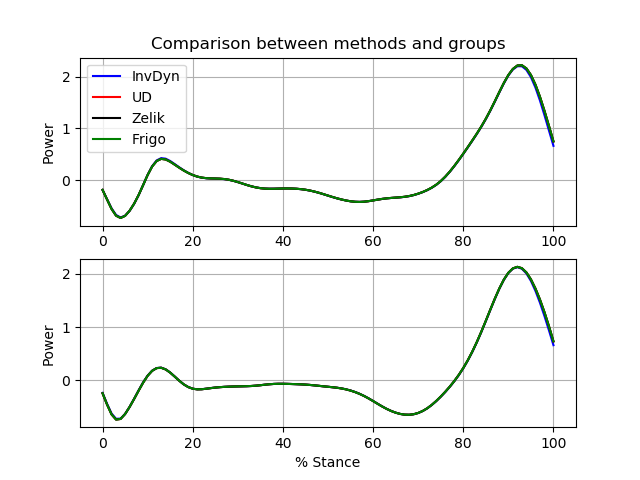

In [81]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(yn3[:,0],'b-', label='InvDyn')
plt.plot(yn3[:,1],'r-', label='UD')
plt.plot(yn3[:,2],'k-', label='Zelik')
plt.plot(yn3[:,3],'g-', label='Frigo')
plt.title('Comparison between methods and groups')
plt.ylabel('Power')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(on3[:,0],'b-', label='InvDyn')
plt.plot(on3[:,1],'r-', label='UD')
plt.plot(on3[:,2],'k-', label='Zelik')
plt.plot(on3[:,3],'g-', label='Frigo')
plt.ylabel('Power')
plt.xlabel('% Stance')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


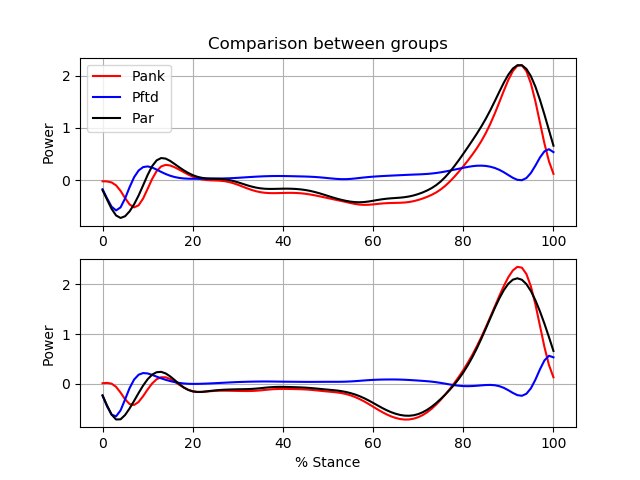

In [82]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(ynp3[:,0],'r-', label='Pank')
plt.plot(ynp3[:,1],'b-', label='Pftd')
plt.plot(ynp3[:,2],'k-', label='Par')
plt.title('Comparison between groups')
plt.ylabel('Power')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(onp3[:,0],'r-', label='Pank')
plt.plot(onp3[:,1],'b-', label='Pftd')
plt.plot(onp3[:,2],'k-', label='Par')
plt.ylabel('Power')
plt.xlabel('% Stance')
plt.grid()
plt.show()

## Young vs Older comparison

<IPython.core.display.Javascript object>


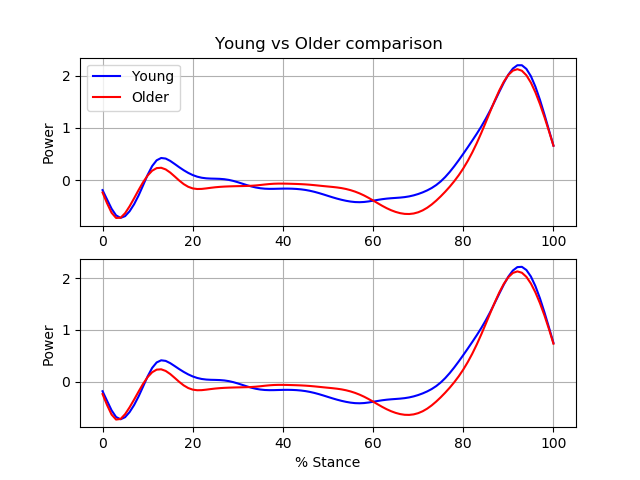

In [83]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(yn3[:,0],'b-', label='Young')
plt.plot(on3[:,0],'r-', label='Older')
plt.title('Young vs Older comparison')
plt.ylabel('Power')
plt.grid()
plt.legend()
plt.subplot(2,1,2)
plt.plot(yn3[:,3],'b-', label='Young')
plt.plot(on3[:,3],'r-', label='Older')
plt.ylabel('Power')
plt.xlabel('% Stance')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


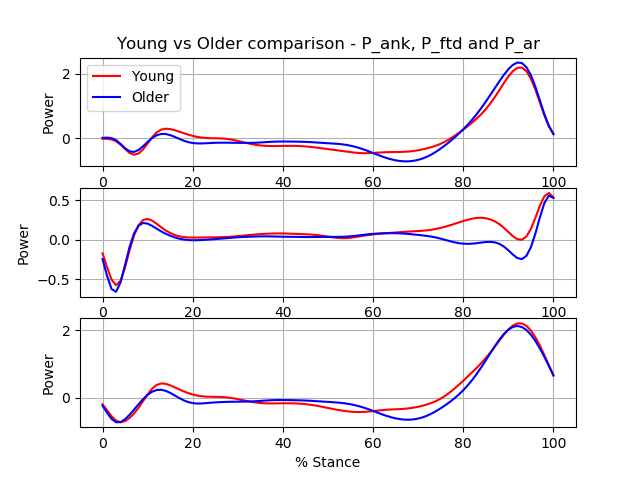

In [84]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(ynp3[:,0],'r-', label='Young')
plt.plot(onp3[:,0],'b-', label='Older')
plt.title('Young vs Older comparison - P_ank, P_ftd and P_ar')
plt.ylabel('Power')
plt.legend()
plt.grid()
plt.subplot(3,1,2)
plt.plot(ynp3[:,1],'r-', label='Young')
plt.plot(onp3[:,1],'b-', label='Older')
plt.ylabel('Power')
plt.xlabel('% Stance')
plt.grid()
plt.show()
plt.subplot(3,1,3)
plt.plot(ynp3[:,2],'r-', label='Young')
plt.plot(onp3[:,2],'b-', label='Older')
plt.ylabel('Power')
plt.xlabel('% Stance')
plt.grid()
plt.show()

## References

[1] A. Leardini, M. G. Benedetti, L. Berti, D. Bettinelli, R. Nativo, and S. Giannini, “Rear-foot, mid-foot and fore-foot motion during the stance phase of gait,” Gait Posture, vol. 25, no. 3, pp. 453–462, Mar. 2007